In [1]:
# zuko is installed in editable mode, so imports should work directly
# No sys.path manipulation needed

### LazyDistribution

PyTorch distributions themselves do not have trainable parameters, because they are not nn.Module subclasses.
A LazyDistribution in Zuko is an nn.Module whose forward method constructs a PyTorch distribution, allowing the parameters that generate the distribution to be learnable.

In [7]:
import torch
from zuko.lazy import LazyDistribution

class LazyNormal(LazyDistribution):
    def __init__(self, mu=0.0, sigma=1.0):
        super().__init__()
        self.mu = torch.nn.Parameter(torch.tensor(mu))
        self.log_sigma = torch.nn.Parameter(torch.log(torch.tensor(sigma)))

    def forward(self, c=None):
        return torch.distributions.Normal(self.mu, torch.exp(self.log_sigma))

In [8]:
# Data Generation Process
true_mu = 4.0
true_sigma = 1.5
y = torch.randn(5000) * true_sigma + true_mu

In [9]:
model = LazyNormal(mu=0.0, sigma=1.0)   # start far away
model().sample((1,3))
model().log_prob(0) 
#... All the pytorch function 

tensor(-0.9189, grad_fn=<SubBackward0>)

In [10]:
model = LazyNormal(mu=0.0, sigma=1.0)   # start far away
opt = torch.optim.Adam(model.parameters(), lr=0.05)

for step in range(3000):
    dist = model()
    loss = -dist.log_prob(y).mean()  # negative log likelihood
    loss.backward()
    opt.step()
    opt.zero_grad()

print("Learned mu:", model.mu.item())
print("Learned sigma:", torch.exp(model.log_sigma).item())
print("Mean of Data:", y.mean().item())
print("Std of Data:", y.std().item())

Learned mu: 4.011692047119141
Learned sigma: 1.49553644657135
Mean of Data: 4.011691570281982
Std of Data: 1.4956858158111572


## Transformations


In [11]:
from zuko.transforms import BernsteinTransform
import zuko

transform = zuko.flows.MaskedAutoregressiveTransform(
    features=1,
    context=0,                                         # no context
    univariate=zuko.transforms.MonotonicRQSTransform, 
    shapes=([8], [8], [7]),                            # shapes of the spline parameters (8 bins)
    hidden_features=(64, 128, 256),                    # size of the hyper-network
)  # fmt: skip


M = 10
transform = zuko.flows.MaskedAutoregressiveTransform(
    features=1,
    context=0,
    univariate=BernsteinTransform,
    order=M, 
    shapes=([M+1],),
    hidden_features=(64, 128, 256),
)
f = transform()

In [12]:
u = f(torch.tensor([-5]))
print(u)
bernstein_transform = f.base 
bernstein_transform(torch.tensor([0]))

tensor([-2.1914], grad_fn=<WhereBackward0>)


tensor([1.9637], grad_fn=<WhereBackward0>)

Bernstein coefficients: [-2.191436290740967, -1.4397213459014893, -0.6880066394805908, -0.33228158950805664, 0.8052833080291748, 1.262683629989624, 2.13337779045105, 2.662520170211792, 3.2032558917999268, 3.4963037967681885, 4.294404983520508, 4.924067497253418, 5.5537309646606445]


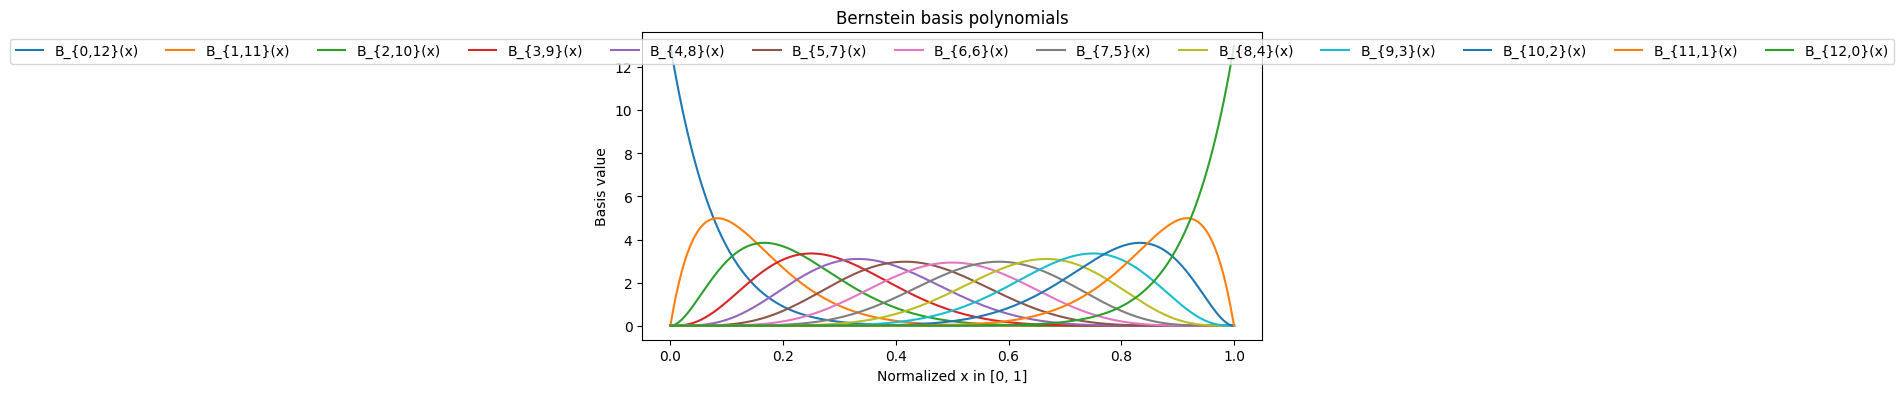

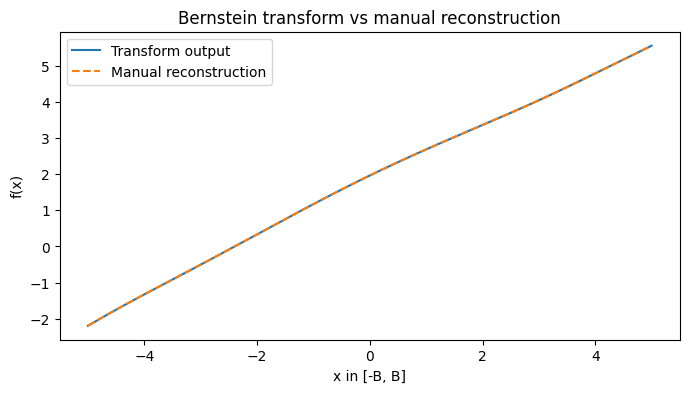

In [14]:
bernstein_transform = f.base  # DependentTransform wraps the Bernstein transform
bernstein_coeffs = bernstein_transform.theta.detach().squeeze()
print("Bernstein coefficients:", bernstein_coeffs.tolist())

order = bernstein_coeffs.shape[-1] - 1
bound = bernstein_transform.bound
x_unit = torch.linspace(bernstein_transform.eps, 1 - bernstein_transform.eps, 400)

# Bernstein basis polynomials on [0, 1]
basis_vals = bernstein_transform.basis.log_prob(x_unit.unsqueeze(-1)).exp().detach()
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
for i in range(order + 1):
    plt.plot(x_unit.numpy(), basis_vals[:, i].numpy(), label=fr"B_{{{i},{order - i}}}(x)")
plt.legend(loc="upper center", ncol=order + 1)
plt.xlabel("Normalized x in [0, 1]")
plt.ylabel("Basis value")
plt.title("Bernstein basis polynomials")
plt.show()

# Manually reconstruct f(x) from basis + coefficients
manual_u = torch.mean(basis_vals * bernstein_coeffs.view(1, -1), dim=-1)
x_full = x_unit * 2 * bound - bound
with torch.no_grad():
    u_transform = bernstein_transform(x_full)

plt.figure(figsize=(8, 4))
plt.plot(x_full.numpy(), u_transform.detach().numpy(), label="Transform output")
plt.plot(x_full.numpy(), manual_u.numpy(), "--", label="Manual reconstruction")
plt.xlabel("x in [-B, B]")
plt.ylabel("f(x)")
plt.title("Bernstein transform vs manual reconstruction")
plt.legend()
plt.show()


### Creating a flow


In [19]:
from zuko.flows import Flow
from zuko.lazy import UnconditionalDistribution
from zuko.distributions import DiagNormal

base = UnconditionalDistribution(DiagNormal, torch.zeros(1), torch.ones(1), buffer=True)
base().sample((1,))

b_flow = Flow(transform=transform, base=base)

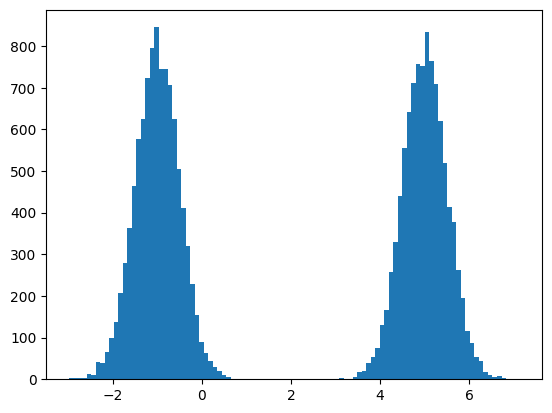

In [20]:
### Create some bimodal data data (-1,3)
y = torch.cat([torch.randn(10000) * 0.5 + 5, torch.randn(10000) * 0.5 - 1])
# histogram of y
plt.hist(y.numpy(), bins=100)
plt.show()

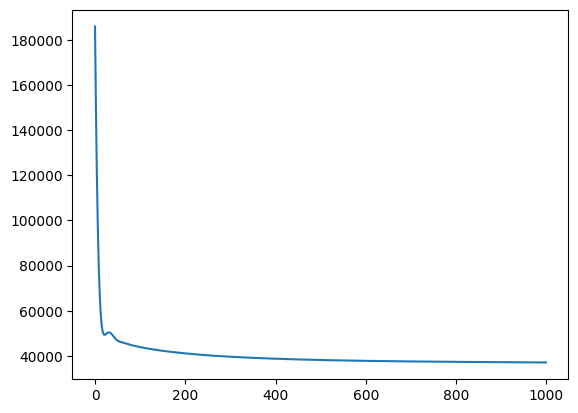

In [21]:
opt = torch.optim.Adam(b_flow.parameters(), lr=0.05)
history = []
for step in range(1000):
    dist = b_flow()
    loss = -dist.log_prob(y).mean()  # negative log likelihood
    loss.backward()
    opt.step()
    opt.zero_grad()
    history.append(loss.detach().numpy())
plt.plot(history)
plt.show()


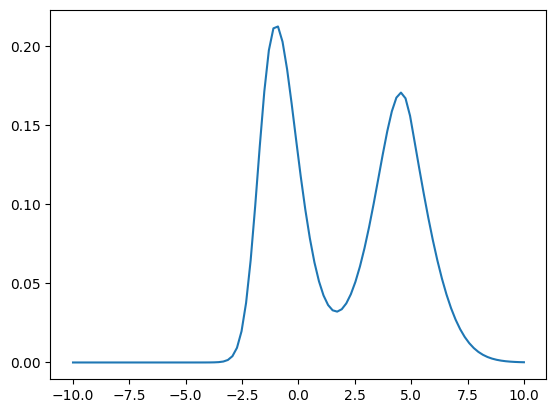

In [22]:
xs = torch.linspace(-10, 10, 100).unsqueeze(-1)
ys = torch.exp(b_flow().log_prob(xs))

sample = b_flow().sample((10000,))
# plt.hist(sample.numpy(), bins=100)
# plt.show()
plt.plot(xs.detach().numpy(), ys.detach().numpy())
#plt.hist(ys.detach().numpy(), bins=100)
plt.show()

## Fist Causal Flow

In [23]:
adjacency = torch.tril(torch.ones(3, 3))
adjacency[2,1] = 0
print(adjacency)

M = 10
transform = zuko.flows.MaskedAutoregressiveTransform(
    features=3,
    context=0,
    adjacency = adjacency,
    univariate=BernsteinTransform,
    order=M, 
    shapes=([M+1],),
    hidden_features=(64, 128, 256),
)
f = transform()

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 0., 1.]])


In [24]:
base = UnconditionalDistribution(DiagNormal, torch.zeros(3), torch.ones(3), buffer=True)
base().sample((1,))

tensor([[ 2.1802, -0.7111, -2.1807]])

In [25]:
from zuko.flows import Flow
b_flow = Flow(transform=transform, base=base)

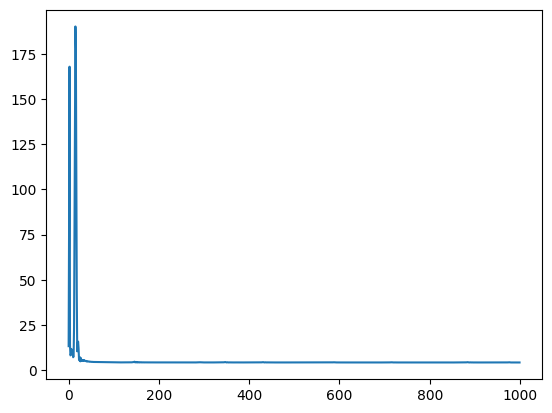

In [26]:
# DGP
# u1,u2,3 = normal(0,1)
# x1 = u1 + 1
# x2 = 1 * x1 + u2 
# x3 = 3 * x1 + u3 

N = 1000
X_train = torch.randn(N, 3)
X_train[:,0] = X_train[:,0] + 1
X_train[:,1] = X_train[:,1] + 1 * X_train[:,0]
X_train[:,2] = X_train[:,2] + 3 * X_train[:,0]

# Fit a flow
opt = torch.optim.Adam(b_flow.parameters(), lr=0.05)
history = []
for step in range(1000):
    dist = b_flow()
    loss = -dist.log_prob(X_train).mean()  # negative log likelihood
    loss.backward()
    opt.step()
    opt.zero_grad()
    history.append(loss.detach().numpy())
plt.plot(history)
plt.show()

### L1 (Pearl hierarchy)

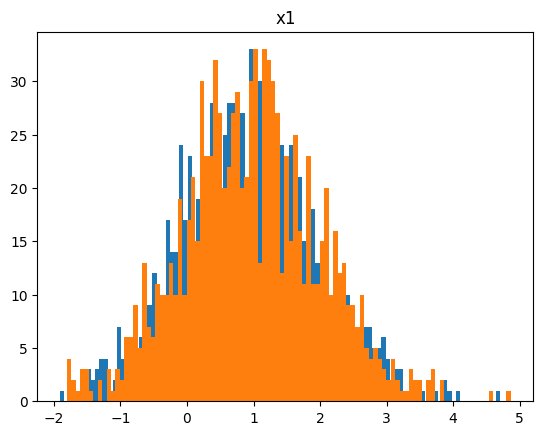

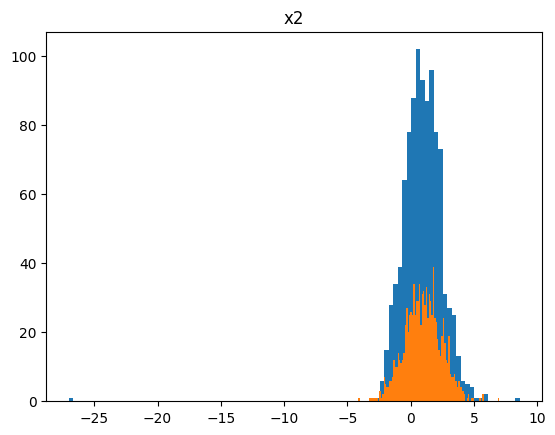

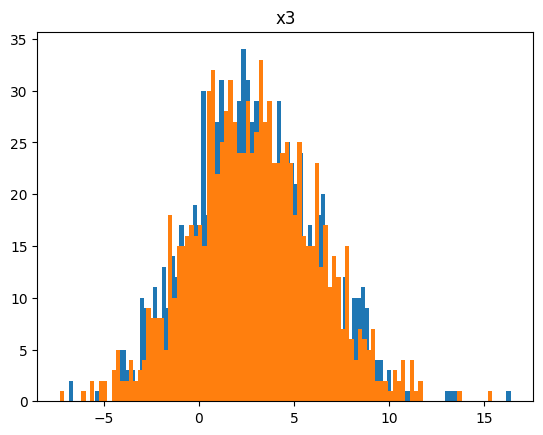

In [27]:
# Make a histogram of the training data draw 1000 samples from the flow and plot them in 3 plots
samples = b_flow().sample((1000,))
plt.hist(samples[:,0].numpy(), bins=100)
plt.hist(X_train[:,0].numpy(), bins=100)
plt.title("x1")
plt.show()
plt.hist(samples[:,1].numpy(), bins=100)
plt.hist(X_train[:,1].numpy(), bins=100)
plt.title("x2")
plt.show()
plt.hist(samples[:,2].numpy(), bins=100)
plt.hist(X_train[:,2].numpy(), bins=100)
plt.title("x3")
plt.show()

### L2 Pearl hierarchy (do(X1=2)
![Do](D1Do.png)


In [28]:
do_value = 2.0
do_index = 0
N = 1000
flow_dist = b_flow()
transform = flow_dist.transform
base_dist = flow_dist.base

u = base_dist.sample((N,))
print("Latent samples shape:", u.shape)

x_obs = transform.inv(u)
print("Observational samples shape:", x_obs.shape)

# do(X1 = 2): clamp the first observed dimension while reusing the latent noise of the other nodes
x_template = torch.zeros_like(x_obs)
x_template[:, do_index] = do_value

u_do = u.clone()
# map the do-value through the forward transform to find the latent associated with x1 = do_value
u_do[:, :1] = transform(x_template)[:, :1]

x_do = transform.inv(u_do)
print("Interventional samples shape:", x_do.shape)
print("Mean of X1 under do(X1=2):", x_do[:, 0].mean().item())
print("Mean of X2 under do(X1=2):", x_do[:, 1].mean().item())
print("Mean of X3 under do(X1=2):", x_do[:, 2].mean().item())


Latent samples shape: torch.Size([1000, 3])
Observational samples shape: torch.Size([1000, 3])
Interventional samples shape: torch.Size([1000, 3])
Mean of X1 under do(X1=2): 1.9999998807907104
Mean of X2 under do(X1=2): 2.037975311279297
Mean of X3 under do(X1=2): 6.306519031524658


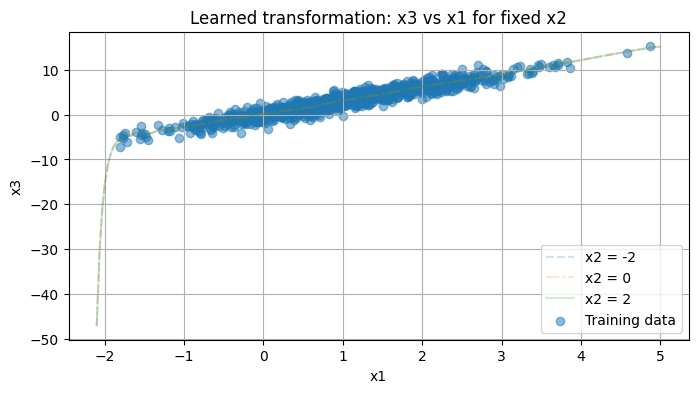

In [34]:
# Visualize the learned transformation: x3 vs x1 for fixed x2 values
flow_dist = b_flow()
transform = flow_dist.transform

x1_vals = torch.linspace(-2.1, 5.0, 200)
x2_settings = torch.tensor([-2.0, 0.0, 2.0])

plt.figure(figsize=(8, 4))
with torch.no_grad():
    for x2_value in x2_settings:
        # Build inputs with varying x1, fixed x2, placeholder x3 (unused for the first two latents)
        x_template = torch.zeros(x1_vals.shape[0], 3)
        x_template[:, 0] = x1_vals
        x_template[:, 1] = x2_value

        u_template = transform(x_template)

        # Keep latents for x1 and x2 consistent with the desired values, fix u3 at 0
        u = torch.zeros_like(x_template)
        u[:, 0] = u_template[:, 0]
        u[:, 1] = u_template[:, 1]
        u[:, 2] = 0.0

        x_result = transform.inv(u)
        styles = ['--', '-.', '-']
        plt.plot(
            x1_vals.detach().numpy(),
            x_result[:, 2].detach().numpy(),
            label=f"x2 = {x2_value.item():.0f}",
            linestyle=styles[list(x2_settings).index(x2_value)],
            alpha=0.2
        )


# Add the training data for x1 on the plot (tick marks)
plt.scatter(X_train[:,0].numpy(), X_train[:,2].numpy(), alpha=0.5, label="Training data")
plt.xlabel("x1")
plt.ylabel("x3")
plt.title("Learned transformation: x3 vs x1 for fixed x2")
plt.legend()
plt.grid(True)
plt.show()



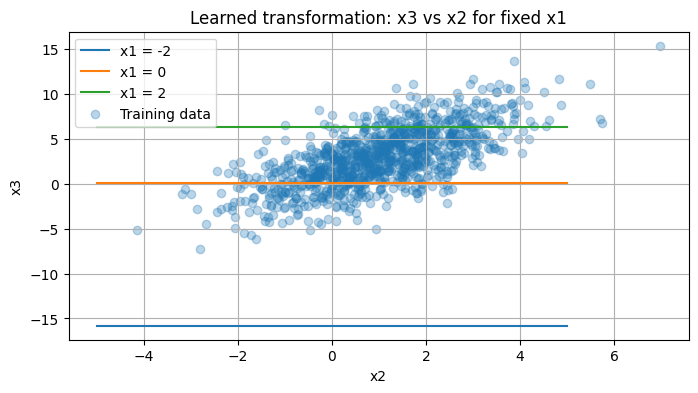

In [35]:
# Visualize the learned transformation: x3 vs x2 for fixed x1 values
flow_dist = b_flow()
transform = flow_dist.transform

x2_vals = torch.linspace(-5.0, 5.0, 200)
x1_settings = torch.tensor([-2.0, 0.0, 2.0])

plt.figure(figsize=(8, 4))
with torch.no_grad():
    for x1_value in x1_settings:
        x_template = torch.zeros(x2_vals.shape[0], 3)
        x_template[:, 0] = x1_value
        x_template[:, 1] = x2_vals

        u_template = transform(x_template)

        u = torch.zeros_like(x_template)
        u[:, 0] = u_template[:, 0]
        u[:, 1] = u_template[:, 1]
        u[:, 2] = 0.0

        x_result = transform.inv(u)
        plt.plot(
            x2_vals.detach().numpy(),
            x_result[:, 2].detach().numpy(),
            label=f"x1 = {x1_value.item():.0f}",
        )

plt.scatter(X_train[:,1].numpy(), X_train[:,2].numpy(), alpha=0.3, label="Training data")
plt.xlabel("x2")
plt.ylabel("x3")
plt.title("Learned transformation: x3 vs x2 for fixed x1")
plt.legend()
plt.grid(True)
plt.show()

